In [5]:
# generic functions
import os
import sys
import random
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit
from inspect import getmembers, isfunction

# tensorflow + keras functions
# tensorflow>=2.10.0
import tensorflow as tf
from tensorflow import keras, convert_to_tensor, string
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow import linalg, ones, maximum, newaxis
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Dense, Layer, Embedding, MaxPooling1D, LSTM
from tensorflow.keras.layers import LayerNormalization, ReLU, Dropout
from tensorflow.keras.layers import Activation, Flatten, Conv1D, BatchNormalization
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence

from keras import backend as K
from keras.backend import softmax

# transformers functions
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer
from transformers import BertConfig, TFBertModel

# graph neural network functions
from spektral.layers import GCNConv, ChebConv, GlobalAvgPool, GATConv, GeneralConv, EdgeConv, ARMAConv
from spektral.utils.convolution import gcn_filter, chebyshev_filter

%load_ext autoreload
%autoreload 2

2023-03-06 15:28:06.246916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:28:06.557309: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 15:28:06.652665: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-06 15:28:07.600043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [6]:
# basic random seed
DEFAULT_RANDOM_SEED = 2022

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
    
# torch random seed
# import torch
# def seedTorch(seed=DEFAULT_RANDOM_SEED):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    # seedTorch(seed)

seedEverything()

In [11]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=10, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
tokenizer.pre_tokenizer = ByteLevel(add_prefix_space = False)
files = [f"token.txt" ]
tokenizer.train(files, trainer)
tokenizer.enable_padding(direction = 'right', pad_id = 0, pad_token = '[PAD]', length = 600)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
tokenizer.save("tokenizer.json")

In [7]:
import models
import functions
model_list = getmembers(models, isfunction)

In [8]:
import functions

In [9]:
model_list

[('cast', <function tensorflow.python.ops.math_ops.cast(x, dtype, name=None)>),
 ('chebyshev_filter',
  <function spektral.utils.convolution.chebyshev_filter(A, k, symmetric=True)>),
 ('convert_to_tensor',
  <function tensorflow.python.framework.ops.convert_to_tensor_v2_with_dispatch(value, dtype=None, dtype_hint=None, name=None)>),
 ('encode_padding',
  <function functions.encode_padding(df, col='utr', seq_len=50, padding='5end', channel=1)>),
 ('gcn_filter',
  <function spektral.utils.convolution.gcn_filter(A, symmetric=True)>),
 ('matmul',
  <function tensorflow.python.ops.math_ops.matmul(a, b, transpose_a=False, transpose_b=False, adjoint_a=False, adjoint_b=False, a_is_sparse=False, b_is_sparse=False, output_type=None, name=None)>),
 ('maximum',
  <function tensorflow.python.ops.gen_math_ops.maximum(x, y, name=None)>),
 ('model1', <function models.model1(seq_length=600, dropout_rate=0.1)>),
 ('model10', <function models.model10(seq_length=600, dropout_rate=0.1)>),
 ('model11', <fun

In [17]:
input_folder = './input/'
output_folder = './output/'
max_input_length = 600
dropout_rate = 0.1
feature_pad_end= '3end'

for model in model_list[1:]:
    
    model_name=model[0]
    if 'model_' not in model_name:
        continue
    
    #if model_name in ['model_embed','model_embed_bert', 'model_embed_bert_conv', 'model_embed_conv',
    #                 'model_onehot_conv', 
    #                 'model_onehot_graph_attention', 'model_embed_graph_attention','model_onehot_graph_conv',
    #                  'model_embed_graph_conv']:
    #    continue
    
    
    custom_model=model[1]
    print(model_name)

    for fold in range(1,11):
        

        print('fold'+str(fold))
        
        data=pd.read_csv(input_folder + '/fold'+str(fold)+'.csv.gz')
        
        data_train=data[data['set']=='train']
        data_valid=data[data['set']=='valid']
        
        train_gen = functions.DataGenerator(data_train, model_name=model_name, tokenizer=tokenizer)
        valid_gen = functions.DataGenerator(data_valid, model_name=model_name, tokenizer=tokenizer, shuffle=False)
    
        tf.keras.backend.clear_session()

        model=custom_model(seq_length=max_input_length, dropout_rate=dropout_rate)

        #adam = tf.keras.optimizers.Adam(LRScheduler(d_model), beta_1=0.9, beta_2=0.999, epsilon=1e-08) 
        adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2, from_logits=False)

        METRICS = [
              keras.metrics.TruePositives(thresholds=0.5, name='tp'),
              keras.metrics.FalsePositives(thresholds=0.5,name='fp'),
              keras.metrics.TrueNegatives(thresholds=0.5,name='tn'),
              keras.metrics.FalseNegatives(thresholds=0.5,name='fn'), 
              keras.metrics.BinaryAccuracy(name='accuracy'),
              keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
              keras.metrics.AUC(name='auc'),
              keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
        
        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2, from_logits=False)

        model.compile(loss=loss, metrics=METRICS, optimizer=adam)
        
        if fold==1:
            print(model.summary())

        es = EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=3, restore_best_weights=True)
        
        #model.fit([train_gen[0][0][0], train_gen[0][0][1]], train_gen[0][1],
        #          batch_size=64, epochs=20,  verbose=1, class_weight={0: 1, 1: 1})

        model.fit(train_gen, validation_data=valid_gen, 
              epochs=20, callbacks = [es], verbose=1, class_weight={0: 10, 1: 1})
        
        with open(output_folder+model_name+'_'+str(fold)+'.json', 'w') as fp:
            json.dump(model.history.history, fp)
            
        if 'graph' in model_name:
            continue
        
        model.save(output_folder+model_name+'_'+str(fold))

model_onehot_structure_conv
fold1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 4)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 600, 3)]     0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 600, 7)       0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 600, 128)     7296   

2023-03-06 11:13:05.683409: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-06 11:13:07.106481: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3997/3997 [==============================] - 144s 35ms/step - loss: 0.0643 - tp: 82789.0000 - fp: 494.0000 - tn: 158007.0000 - fn: 14518.0000 - accuracy: 0.9413 - precision: 0.9941 - recall: 0.8508 - auc: 0.9944 - prc: 0.9918 - val_loss: 0.0142 - val_tp: 21.0000 - val_fp: 59.0000 - val_tn: 7493.0000 - val_fn: 43.0000 - val_accuracy: 0.9866 - val_precision: 0.2625 - val_recall: 0.3281 - val_auc: 0.8600 - val_prc: 0.3714
Epoch 2/20
3997/3997 [==============================] - 140s 35ms/step - loss: 0.0068 - tp: 96149.0000 - fp: 91.0000 - tn: 158411.0000 - fn: 1157.0000 - accuracy: 0.9951 - precision: 0.9991 - recall: 0.9881 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0163 - val_tp: 22.0000 - val_fp: 34.0000 - val_tn: 7518.0000 - val_fn: 42.0000 - val_accuracy: 0.9900 - val_precision: 0.3929 - val_recall: 0.3438 - val_auc: 0.8518 - val_prc: 0.3849
Epoch 3/20
3997/3997 [==============================] - 140s 35ms/step - loss: 0.0030 - tp: 96824.0000 - fp: 40.0000 - tn: 158459.0000 - fn: 485.

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_1/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_1/assets


fold2
Epoch 1/20
3582/3582 [==============================] - 135s 37ms/step - loss: 0.0626 - tp: 73232.0000 - fp: 431.0000 - tn: 142791.0000 - fn: 12794.0000 - accuracy: 0.9423 - precision: 0.9941 - recall: 0.8513 - auc: 0.9947 - prc: 0.9920 - val_loss: 0.0304 - val_tp: 196.0000 - val_fp: 387.0000 - val_tn: 22486.0000 - val_fn: 163.0000 - val_accuracy: 0.9763 - val_precision: 0.3362 - val_recall: 0.5460 - val_auc: 0.8863 - val_prc: 0.3771
Epoch 2/20
3582/3582 [==============================] - 133s 37ms/step - loss: 0.0056 - tp: 85146.0000 - fp: 66.0000 - tn: 143160.0000 - fn: 876.0000 - accuracy: 0.9959 - precision: 0.9992 - recall: 0.9898 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0463 - val_tp: 50.0000 - val_fp: 29.0000 - val_tn: 22844.0000 - val_fn: 309.0000 - val_accuracy: 0.9855 - val_precision: 0.6329 - val_recall: 0.1393 - val_auc: 0.8341 - val_prc: 0.3214
Epoch 3/20
3582/3582 [==============================] - 133s 37ms/step - loss: 0.0026 - tp: 85676.0000 - fp: 27.0000 - tn: 

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_2/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_2/assets


fold3
Epoch 1/20
3730/3730 [==============================] - 140s 37ms/step - loss: 0.0579 - tp: 78133.0000 - fp: 391.0000 - tn: 147819.0000 - fn: 12377.0000 - accuracy: 0.9465 - precision: 0.9950 - recall: 0.8633 - auc: 0.9956 - prc: 0.9934 - val_loss: 0.0539 - val_tp: 32.0000 - val_fp: 1023.0000 - val_tn: 16866.0000 - val_fn: 191.0000 - val_accuracy: 0.9330 - val_precision: 0.0303 - val_recall: 0.1435 - val_auc: 0.7931 - val_prc: 0.0323
Epoch 2/20
3730/3730 [==============================] - 138s 37ms/step - loss: 0.0059 - tp: 89591.0000 - fp: 74.0000 - tn: 148134.0000 - fn: 921.0000 - accuracy: 0.9958 - precision: 0.9992 - recall: 0.9898 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0461 - val_tp: 15.0000 - val_fp: 497.0000 - val_tn: 17392.0000 - val_fn: 208.0000 - val_accuracy: 0.9611 - val_precision: 0.0293 - val_recall: 0.0673 - val_auc: 0.7795 - val_prc: 0.0290
Epoch 3/20
3730/3730 [==============================] - 138s 37ms/step - loss: 0.0026 - tp: 90123.0000 - fp: 37.0000 - tn:

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_3/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_3/assets


fold4
Epoch 1/20
3945/3945 [==============================] - 136s 34ms/step - loss: 0.0501 - tp: 80566.0000 - fp: 357.0000 - tn: 160396.0000 - fn: 11161.0000 - accuracy: 0.9544 - precision: 0.9956 - recall: 0.8783 - auc: 0.9966 - prc: 0.9946 - val_loss: 0.1336 - val_tp: 56.0000 - val_fp: 55.0000 - val_tn: 5281.0000 - val_fn: 304.0000 - val_accuracy: 0.9370 - val_precision: 0.5045 - val_recall: 0.1556 - val_auc: 0.7356 - val_prc: 0.2273
Epoch 2/20
3945/3945 [==============================] - 135s 34ms/step - loss: 0.0047 - tp: 90970.0000 - fp: 65.0000 - tn: 160686.0000 - fn: 759.0000 - accuracy: 0.9967 - precision: 0.9993 - recall: 0.9917 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.1132 - val_tp: 82.0000 - val_fp: 128.0000 - val_tn: 5208.0000 - val_fn: 278.0000 - val_accuracy: 0.9287 - val_precision: 0.3905 - val_recall: 0.2278 - val_auc: 0.8369 - val_prc: 0.2792
Epoch 3/20
3945/3945 [==============================] - 136s 34ms/step - loss: 0.0022 - tp: 91436.0000 - fp: 28.0000 - tn: 160

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_4/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_4/assets


fold5
Epoch 1/20
3775/3775 [==============================] - 137s 36ms/step - loss: 0.0634 - tp: 78912.0000 - fp: 393.0000 - tn: 148554.0000 - fn: 13741.0000 - accuracy: 0.9415 - precision: 0.9950 - recall: 0.8517 - auc: 0.9948 - prc: 0.9923 - val_loss: 0.0256 - val_tp: 67.0000 - val_fp: 641.0000 - val_tn: 16500.0000 - val_fn: 8.0000 - val_accuracy: 0.9623 - val_precision: 0.0946 - val_recall: 0.8933 - val_auc: 0.9515 - val_prc: 0.7102
Epoch 2/20
3775/3775 [==============================] - 136s 36ms/step - loss: 0.0070 - tp: 91528.0000 - fp: 87.0000 - tn: 148859.0000 - fn: 1126.0000 - accuracy: 0.9950 - precision: 0.9991 - recall: 0.9878 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0267 - val_tp: 67.0000 - val_fp: 485.0000 - val_tn: 16656.0000 - val_fn: 8.0000 - val_accuracy: 0.9714 - val_precision: 0.1214 - val_recall: 0.8933 - val_auc: 0.9584 - val_prc: 0.5103
Epoch 3/20
3775/3775 [==============================] - 136s 36ms/step - loss: 0.0032 - tp: 92186.0000 - fp: 45.0000 - tn: 148

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_5/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_5/assets


fold6
Epoch 1/20
3758/3758 [==============================] - 140s 37ms/step - loss: 0.0561 - tp: 79385.0000 - fp: 413.0000 - tn: 148786.0000 - fn: 11928.0000 - accuracy: 0.9487 - precision: 0.9948 - recall: 0.8694 - auc: 0.9960 - prc: 0.9939 - val_loss: 0.0396 - val_tp: 43.0000 - val_fp: 471.0000 - val_tn: 16404.0000 - val_fn: 170.0000 - val_accuracy: 0.9625 - val_precision: 0.0837 - val_recall: 0.2019 - val_auc: 0.6840 - val_prc: 0.0586
Epoch 2/20
3758/3758 [==============================] - 139s 37ms/step - loss: 0.0068 - tp: 90194.0000 - fp: 79.0000 - tn: 149119.0000 - fn: 1120.0000 - accuracy: 0.9950 - precision: 0.9991 - recall: 0.9877 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0639 - val_tp: 54.0000 - val_fp: 746.0000 - val_tn: 16129.0000 - val_fn: 159.0000 - val_accuracy: 0.9470 - val_precision: 0.0675 - val_recall: 0.2535 - val_auc: 0.6092 - val_prc: 0.1904
Epoch 3/20
3758/3758 [==============================] - 138s 37ms/step - loss: 0.0026 - tp: 90912.0000 - fp: 39.0000 - tn:

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_6/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_6/assets


fold7
Epoch 1/20
3579/3579 [==============================] - 135s 37ms/step - loss: 0.0561 - tp: 77271.0000 - fp: 409.0000 - tn: 140551.0000 - fn: 10825.0000 - accuracy: 0.9510 - precision: 0.9947 - recall: 0.8771 - auc: 0.9959 - prc: 0.9940 - val_loss: 0.0446 - val_tp: 35.0000 - val_fp: 1266.0000 - val_tn: 23900.0000 - val_fn: 143.0000 - val_accuracy: 0.9444 - val_precision: 0.0269 - val_recall: 0.1966 - val_auc: 0.7170 - val_prc: 0.0408
Epoch 2/20
3579/3579 [==============================] - 134s 37ms/step - loss: 0.0061 - tp: 87218.0000 - fp: 82.0000 - tn: 140879.0000 - fn: 877.0000 - accuracy: 0.9958 - precision: 0.9991 - recall: 0.9900 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0847 - val_tp: 67.0000 - val_fp: 2469.0000 - val_tn: 22697.0000 - val_fn: 111.0000 - val_accuracy: 0.8982 - val_precision: 0.0264 - val_recall: 0.3764 - val_auc: 0.7491 - val_prc: 0.0595
Epoch 3/20
3579/3579 [==============================] - 133s 37ms/step - loss: 0.0025 - tp: 87748.0000 - fp: 31.0000 - tn

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_7/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_7/assets


fold8
Epoch 1/20
3939/3939 [==============================] - 141s 35ms/step - loss: 0.0629 - tp: 79292.0000 - fp: 438.0000 - tn: 158634.0000 - fn: 13732.0000 - accuracy: 0.9438 - precision: 0.9945 - recall: 0.8524 - auc: 0.9941 - prc: 0.9911 - val_loss: 0.0804 - val_tp: 78.0000 - val_fp: 55.0000 - val_tn: 6967.0000 - val_fn: 260.0000 - val_accuracy: 0.9572 - val_precision: 0.5865 - val_recall: 0.2308 - val_auc: 0.8713 - val_prc: 0.3581
Epoch 2/20
3939/3939 [==============================] - 139s 35ms/step - loss: 0.0060 - tp: 92045.0000 - fp: 61.0000 - tn: 159011.0000 - fn: 979.0000 - accuracy: 0.9959 - precision: 0.9993 - recall: 0.9895 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.1541 - val_tp: 44.0000 - val_fp: 26.0000 - val_tn: 6996.0000 - val_fn: 294.0000 - val_accuracy: 0.9565 - val_precision: 0.6286 - val_recall: 0.1302 - val_auc: 0.8481 - val_prc: 0.3078
Epoch 3/20
3939/3939 [==============================] - 139s 35ms/step - loss: 0.0028 - tp: 92605.0000 - fp: 33.0000 - tn: 1590

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_8/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_8/assets


fold9
Epoch 1/20
3606/3606 [==============================] - 134s 37ms/step - loss: 0.0587 - tp: 75167.0000 - fp: 456.0000 - tn: 143260.0000 - fn: 11901.0000 - accuracy: 0.9465 - precision: 0.9940 - recall: 0.8633 - auc: 0.9957 - prc: 0.9934 - val_loss: 0.0591 - val_tp: 146.0000 - val_fp: 1548.0000 - val_tn: 20834.0000 - val_fn: 128.0000 - val_accuracy: 0.9260 - val_precision: 0.0862 - val_recall: 0.5328 - val_auc: 0.7848 - val_prc: 0.2392
Epoch 2/20
3606/3606 [==============================] - 132s 37ms/step - loss: 0.0064 - tp: 86137.0000 - fp: 83.0000 - tn: 143636.0000 - fn: 928.0000 - accuracy: 0.9956 - precision: 0.9990 - recall: 0.9893 - auc: 1.0000 - prc: 0.9999 - val_loss: 0.0881 - val_tp: 152.0000 - val_fp: 2380.0000 - val_tn: 20002.0000 - val_fn: 122.0000 - val_accuracy: 0.8896 - val_precision: 0.0600 - val_recall: 0.5547 - val_auc: 0.7931 - val_prc: 0.2706
Epoch 3/20
3606/3606 [==============================] - 132s 37ms/step - loss: 0.0022 - tp: 86785.0000 - fp: 26.0000 - 

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_9/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_9/assets


fold10
Epoch 1/20
3962/3962 [==============================] - 140s 35ms/step - loss: 0.0644 - tp: 82287.0000 - fp: 509.0000 - tn: 156450.0000 - fn: 14322.0000 - accuracy: 0.9415 - precision: 0.9939 - recall: 0.8518 - auc: 0.9944 - prc: 0.9918 - val_loss: 0.0174 - val_tp: 102.0000 - val_fp: 55.0000 - val_tn: 9045.0000 - val_fn: 14.0000 - val_accuracy: 0.9925 - val_precision: 0.6497 - val_recall: 0.8793 - val_auc: 0.9928 - val_prc: 0.6218
Epoch 2/20
3962/3962 [==============================] - 138s 35ms/step - loss: 0.0072 - tp: 95379.0000 - fp: 89.0000 - tn: 156868.0000 - fn: 1232.0000 - accuracy: 0.9948 - precision: 0.9991 - recall: 0.9872 - auc: 0.9999 - prc: 0.9999 - val_loss: 0.0236 - val_tp: 103.0000 - val_fp: 112.0000 - val_tn: 8988.0000 - val_fn: 13.0000 - val_accuracy: 0.9864 - val_precision: 0.4791 - val_recall: 0.8879 - val_auc: 0.9908 - val_prc: 0.6148
Epoch 3/20
3962/3962 [==============================] - 138s 35ms/step - loss: 0.0028 - tp: 96179.0000 - fp: 29.0000 - tn: 1

INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_10/assets


INFO:tensorflow:Assets written to: ./output/model_onehot_structure_conv_10/assets


In [16]:
input_folder = './input/'
output_folder = './output/'
max_input_length = 600
dropout_rate = 0.1
feature_pad_end= '3end'

for model in model_list[1:]:
    
    model_name=model[0]
    if 'model_' not in model_name:
        continue
    
    if model_name in ['model_embed','model_embed_bert', 'model_embed_bert_conv', 'model_embed_conv',
                     'model_onehot_conv', 
                     'model_onehot_graph_attention', 'model_embed_graph_attention','model_onehot_graph_conv',
                      'model_embed_graph_conv']:
        continue
    
    
    custom_model=model[1]
    print(model_name)

    for fold in range(1,11):
        

        print('fold'+str(fold))
        
        data=pd.read_csv(input_folder + '/fold'+str(fold)+'.csv.gz')
        
        data_train=data[data['set']=='train']
        data_valid=data[data['set']=='valid']
        
        train_gen = functions.DataGenerator(data_train, model_name=model_name, tokenizer=tokenizer)
        valid_gen = functions.DataGenerator(data_valid, model_name=model_name, tokenizer=tokenizer, shuffle=False)
    
        tf.keras.backend.clear_session()

        model=custom_model(seq_length=max_input_length, dropout_rate=dropout_rate)

        #adam = tf.keras.optimizers.Adam(LRScheduler(d_model), beta_1=0.9, beta_2=0.999, epsilon=1e-08) 
        adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2, from_logits=False)

        METRICS = [
              keras.metrics.TruePositives(thresholds=0.5, name='tp'),
              keras.metrics.FalsePositives(thresholds=0.5,name='fp'),
              keras.metrics.TrueNegatives(thresholds=0.5,name='tn'),
              keras.metrics.FalseNegatives(thresholds=0.5,name='fn'), 
              keras.metrics.BinaryAccuracy(name='accuracy'),
              keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
              keras.metrics.AUC(name='auc'),
              keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
        
        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2, from_logits=False)

        model.compile(loss=loss, metrics=METRICS, optimizer=adam)
        
        if fold==1:
            print(model.summary())

        es = EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=3, restore_best_weights=True)
        
        #model.fit([train_gen[0][0][0], train_gen[0][0][1]], train_gen[0][1],
        #          batch_size=64, epochs=20,  verbose=1, class_weight={0: 1, 1: 1})

        #model.fit(train_gen, validation_data=valid_gen, 
        #      epochs=20, callbacks = [es], verbose=1, class_weight={0: 10, 1: 1})
        
        #with open(output_folder+model_name+'_'+str(fold)+'.json', 'w') as fp:
        #    json.dump(model.history.history, fp)
        
        # model.save(output_folder+model_name+'_'+str(fold))

model_onehot_structure_conv
fold1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 4)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 600, 3)]     0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 600, 7)       0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 600, 128)     7296   

2023-03-06 11:12:27.962829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 11:12:28.974000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22808 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:65:00.0, compute capability: 7.5


None
fold2
fold3
fold4
fold5
fold6
fold7
fold8
fold9
fold10


In [10]:
# generic functions
import os
import sys
import random
import json
import pandas as pd
import numpy as np

input_folder = './input/'
output_folder = './output/'
tp=[]
fp=[]
tn=[]
fn=[]
precision=[]
recall=[]
auc=[]
prc=[]
fold = []
m = []

for model in model_list[1:]:
    
    model_name=model[0]
    if 'model_' not in model_name:
        continue
        
    for j in range(1,11):
            #print(j)
            f = open(output_folder + model_name +'_'+str(j)+'.json')
            result = json.load(f)
            f.close()
            max_prc = max(result['val_prc'])
            index_max = result['val_prc'].index(max_prc)
            tp.append(result['val_tp'][index_max])
            fp.append(result['val_fp'][index_max])
            tn.append(result['val_tn'][index_max])
            fn.append(result['val_fp'][index_max])
            precision.append(result['val_precision'][index_max])
            recall.append(result['val_recall'][index_max])
            auc.append(result['val_auc'][index_max])
            prc.append(max_prc)
            fold.append(j)
            m.append(model_name)


result=pd.DataFrame({"tp":tp,
                     "fp":fp,
                     "tn":tn,
                     "fn":fn,
                     "precision":precision,
                     "recall":recall,
                     "auc":auc,
                     "prc":prc,
                     "fold":fold,
                     "model":m
                    })

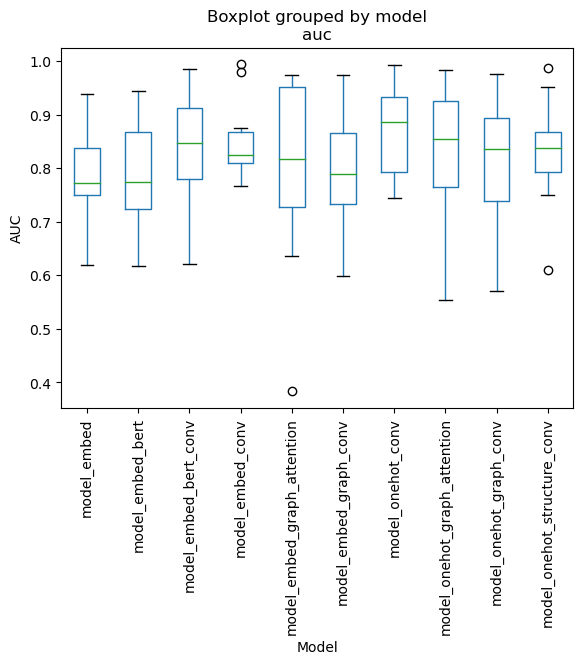

In [19]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Use the boxplot() method on the dataframe
result.boxplot(column='auc', by='model', ax=ax)

# Set the axis label
ax.set_ylabel('AUC')
ax.set_xlabel('Model')

plt.xticks(rotation=90)
plt.grid(False)

# Show the plot
plt.show()

In [12]:
result.groupby(['model']).mean()

,tp,fp,tn,fn,precision,recall,auc,prc,fold
model,,,,,,,,,
model_embed,79.7,732.0,14401.6,732.0,0.186594,0.426841,0.787234,0.266450,5.5
model_embed_bert,83.4,610.5,14523.1,610.5,0.227503,0.438501,0.789070,0.318238,5.5
model_embed_bert_conv,72.4,584.1,14549.5,584.1,0.341832,0.401564,0.833671,0.305911,5.5
model_embed_conv,84.7,554.1,14579.5,554.1,0.392422,0.455728,0.851119,0.368571,5.5
model_embed_graph_attention,79.3,547.0,14586.6,547.0,0.446158,0.416394,0.793615,0.366206,5.5
model_embed_graph_conv,83.0,676.1,14457.5,676.1,0.403832,0.429385,0.793871,0.364565,5.5
model_onehot_conv,79.0,239.0,14894.6,239.0,0.418791,0.415809,0.872779,0.394424,5.5
model_onehot_graph_attention,61.7,185.8,14947.8,185.8,0.446695,0.333025,0.816531,0.360711,5.5
model_onehot_graph_conv,75.5,533.5,14600.1,533.5,0.382837,0.412501,0.810056,0.367430,5.5


In [21]:
import shap

In [23]:
from keras.models import load_model

# Load the model
model_test = load_model('output/model_onehot_conv_1/')


In [ ]:
# select backgroud for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)

In [24]:
model_test

In [29]:
iterator = iter(valid_gen)
X_temp, y_temp = next(iterator)

In [ ]:
# select a set of background examples to take an expectation over
background = np.zeros((1, 600, 4))
# explain predictions of the model on three images
e = shap.DeepExplainer(model_test, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_temp[0])

In [ ]:
shap_values[0][0]

In [ ]:
plt.hist(shap_values.flatten())
plt.show()

In [ ]:
threshold = 0.02
# Extract short motifs based on the thresholded SHAP values
motifs = []
for i in range(shap_values.shape[1]):
    indices = np.where(np.abs(shap_values[:, i]) > threshold)[0]
    if len(indices) > 0:
        motifs.append((i, indices))

# Print the extracted motifs
print(motifs)

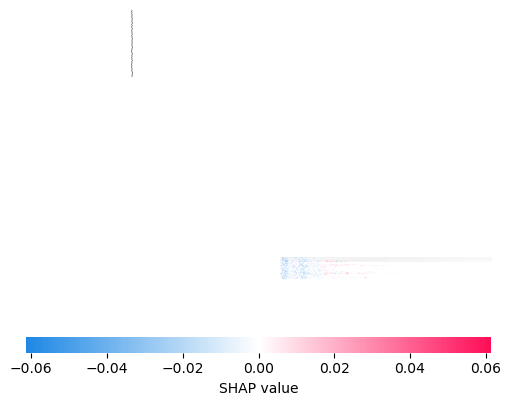

In [75]:
shap.plot.te(shap_values, -X_temp[0][0])

In [62]:
shap_values[0].shape

(64, 600, 4)

In [73]:
shap_values[0][0]

array([[-0.00460897,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.00592468],
       [ 0.        ,  0.        ,  0.        ,  0.0003384 ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

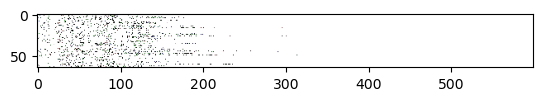

In [74]:
import matplotlib.pyplot as plt
plt.imshow(shap_values[0]*1000)